# Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tf_keras as k
from tf_keras.layers import *
from tf_keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

from modules import train_model, plot_time_series, evaluate_preds, save_dict_to_json, plot_loss_and_prediction, get_results_table

import matplotlib.pyplot as plt

# Load Datasets

loading them in pandas

In [2]:
PATH = 'data/'
columns_to_drop = ['Date', 'Open', 'High', 'Low', 'Close + 7', 'Close + 8', 'Close + 9', 'Close + 10', 'Close + 11',
       'Close + 12', 'Close + 13', 'Close + 14', 'Close + 15',
       'Close + 16', 'Close + 17', 'Close + 18', 'Close + 19',
       'Close + 20', 'Close + 21', 'Close + 22', 'Close + 23',
       'Close + 24', 'Close + 25', 'Close + 26', 'Close + 27',
       'Close + 28', 'Close + 29', 'Close + 30']
train_df = pd.read_csv(PATH+'train_dataset.csv').drop(columns=columns_to_drop)
valid_df = pd.read_csv(PATH+'valid_dataset.csv').drop(columns=columns_to_drop)
test_df = pd.read_csv(PATH+'test_dataset.csv').drop(columns=columns_to_drop)

In [3]:
train_df.head(3)

,Volume,value,value_classification,Close + 1,Close + 2,Close + 3,Close + 4,Close + 5,Close + 6,MA_13,MA_21,RSI_3,%K,%D,Close
0,6690570240,56,4,11086.400391,10951.000000,10397.900391,10725.599609,10366.700195,9664.730469,10624.661659,10254.042015,100.0,100.0,100.0,11489.700195
1,6084149760,44,1,11489.700195,11086.400391,10951.000000,10397.900391,10725.599609,10366.700195,10646.761644,10415.119606,100.0,100.0,100.0,11512.599609
2,6468539904,55,4,11512.599609,11489.700195,11086.400391,10951.000000,10397.900391,10725.599609,10659.807767,10541.154343,100.0,100.0,100.0,11573.299805


In [4]:
train_df.columns.values

array(['Volume', 'value', 'value_classification', 'Close + 1',
       'Close + 2', 'Close + 3', 'Close + 4', 'Close + 5', 'Close + 6',
       'MA_13', 'MA_21', 'RSI_3', '%K', '%D', 'Close'], dtype=object)

turning datasets into np.array

In [5]:
scaler = MinMaxScaler()

In [6]:
columns_to_scale = ['Volume', 'value', 'Close + 1',
       'Close + 2', 'Close + 3', 'Close + 4', 'Close + 5', 'Close + 6',
        'MA_13', 'MA_21',
       'RSI_3', '%K', '%D', 'Close']
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
valid_df[columns_to_scale] = scaler.transform(valid_df[columns_to_scale])
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

X_train, y_train = np.array(train_df.iloc[:, :-1]), np.array(train_df.iloc[:, -1]) 
X_valid, y_valid = np.array(valid_df.iloc[:, :-1]), np.array(valid_df.iloc[:, -1]) 
X_test, y_test = np.array(test_df.iloc[:, :-1]), np.array(test_df.iloc[:, -1])

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_valid = np.reshape(X_valid, (X_valid.shape[0], 1, X_valid.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [7]:
# Fast save function
def fast_save(model, model_name):
    y_train_pred = model.predict(X_train, verbose=0)
    y_valid_pred = model.predict(X_valid, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)
    save_dict_to_json(evaluate_preds(y_train, y_train_pred), filename=f'results/train/{model_name}.json')
    save_dict_to_json(evaluate_preds(y_valid, y_valid_pred), filename=f'results/valid/{model_name}.json')
    save_dict_to_json(evaluate_preds(y_test, y_test_pred), filename=f'results/test/{model_name}.json')

# Training

In [10]:
callback = [k.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
metrics=[k.metrics.MeanSquaredError(), 
         k.metrics.RootMeanSquaredError(),
         k.metrics.MeanAbsolutePercentageError(),
         k.metrics.MeanAbsoluteError()]
loss_fn = k.losses.MeanSquaredError()

## LSTM

In [11]:
tf.random.set_seed(42)
model_0 = Sequential([
    LSTM(units=64, 
         input_shape=(1, X_train.shape[2]), 
         activation='relu'),
    Dense(units=1)
])

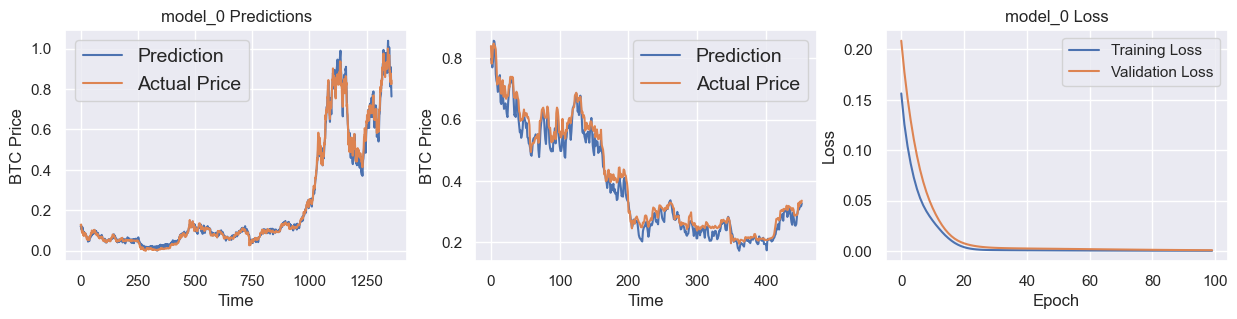

In [12]:
tf.random.set_seed(42)
model_0_history = train_model(
    model=model_0,
    model_name='model_0',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_0, 'model_0_LSTM')

## Bidirectional LSTM

In [13]:
tf.random.set_seed(42)
model_1 = Sequential([
    Bidirectional(LSTM(units=64, 
                       input_shape=(1, X_train.shape[2]), 
                       activation='relu')),
    Dense(1),
])

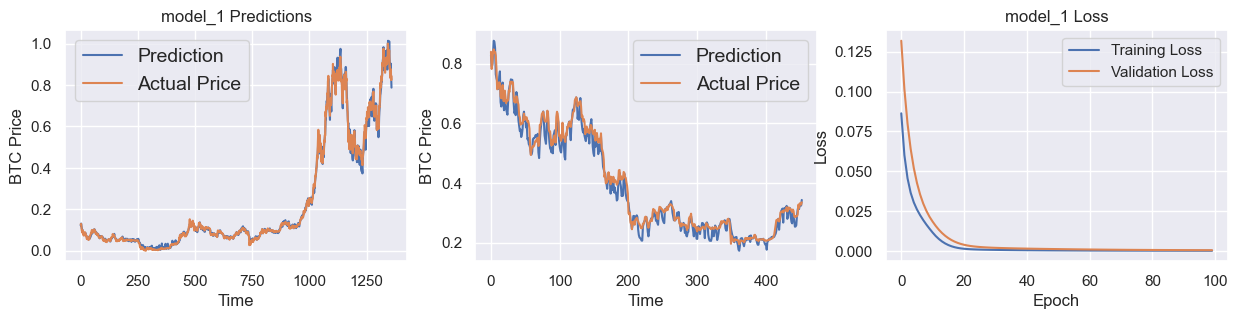

In [14]:
tf.random.set_seed(42)
model_1_history = train_model(
    model=model_1,
    model_name='model_1',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_1, 'model_1_BiLSTM')

## Encoder-Decoder LSTM

In [15]:
tf.random.set_seed(42)
model_2 = Sequential([
    LSTM(units=64, 
         input_shape=(1, X_train.shape[2]), 
         activation='relu'),
    RepeatVector(1),
    LSTM(64, 
         activation='relu',
         return_sequences=True),
    TimeDistributed(Dense(1)),
])

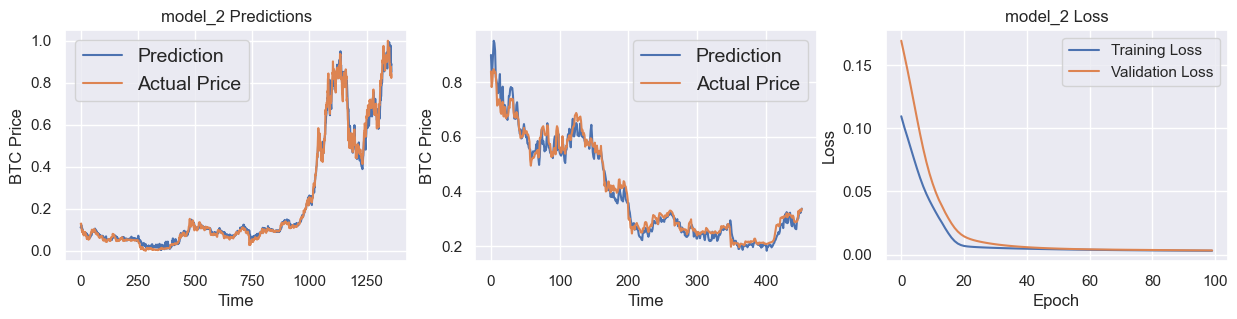

In [16]:
tf.random.set_seed(42)
model_2_history = train_model(
    model=model_2,
    model_name='model_2',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_2, 'model_2_EDLSTM')

## Convolutional LSTM

In [17]:
tf.random.set_seed(42)
model_3 = Sequential([
    Conv1D(
         filters=64,
         kernel_size=1, 
         activation='relu',
         input_shape=(1, X_train.shape[2]),
    ),
    LSTM(64,
         activation='relu',
    ),
    Dense(20, activation='relu'),
    Dense(1)
])

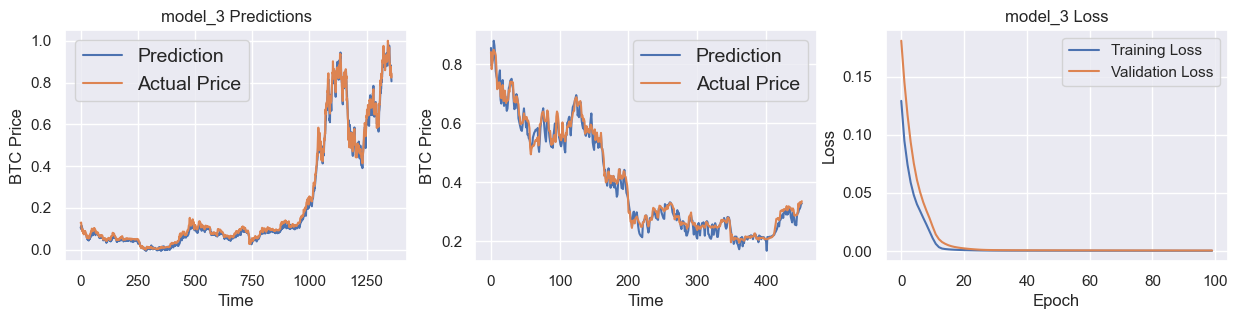

In [18]:
tf.random.set_seed(42)
model_3_history = train_model(
    model=model_3,
    model_name='model_3',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_3, 'model_3_ConvLSTM')

## Comparison of each model

### Train

In [19]:
train_res_dir = 'results/train'
train_results = get_results_table(train_res_dir)
train_results

,mae,mse,rmse,mape,mase,model
0,0.009177,0.000177,0.009177,6182.469727,33.439613,bilstm128
1,0.011190,0.000212,0.011190,860.659485,33.531212,bilstm256
2,0.011767,0.000316,0.011767,14897.711914,33.297596,model_0_LSTM
3,0.008653,0.000205,0.008653,11859.985352,33.379402,model_1_BiLSTM
4,0.259376,0.145218,0.363093,168946.750000,33.057571,model_2_EDLSTM
5,0.012908,0.000273,0.012908,1278.844238,33.420368,model_3_ConvLSTM
6,0.007846,0.000237,0.015406,71.689896,0.999298,naive


### Valid

In [20]:
valid_res_dir = 'results/valid'
valid_results = get_results_table(valid_res_dir)
valid_results

,mae,mse,rmse,mape,mase,model
0,0.014253,0.000353,0.014253,3.721862,18.613663,bilstm128
1,0.012578,0.000280,0.012578,3.294676,18.679541,bilstm256
2,0.023351,0.000870,0.023351,6.024514,18.497587,model_0_LSTM
3,0.017689,0.000562,0.017689,4.593501,18.584332,model_1_BiLSTM
4,0.198839,0.065406,0.248781,54.399033,19.037094,model_2_EDLSTM
5,0.015215,0.000392,0.015215,4.077656,18.741831,model_3_ConvLSTM
6,0.010445,0.000267,0.016341,2.548672,1.010110,naive


# Testing

## Naive Forecast

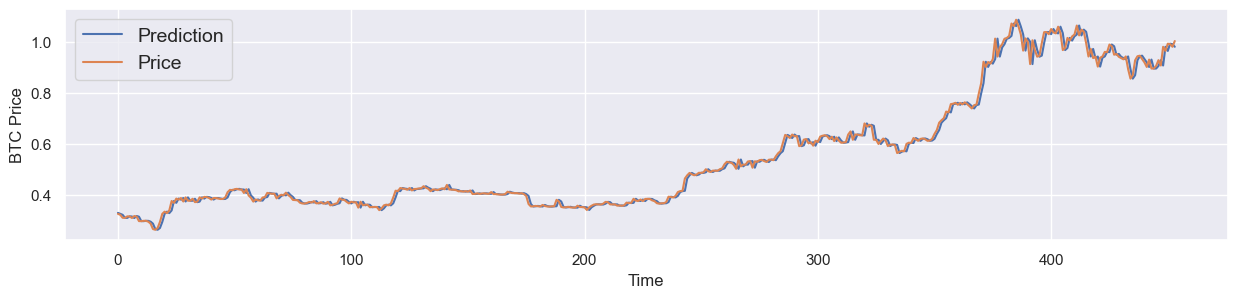

In [21]:
y_naive_test = y_test[:-1]
plt.figure(figsize=(15, 3))
plot_time_series(y_naive_test, format='-', label='Prediction')
plot_time_series(y_test[1:], format='-', label='Price')
save_dict_to_json(evaluate_preds(y_test[1:], y_naive_test), filename='results/test/naive.json')

## LSTM

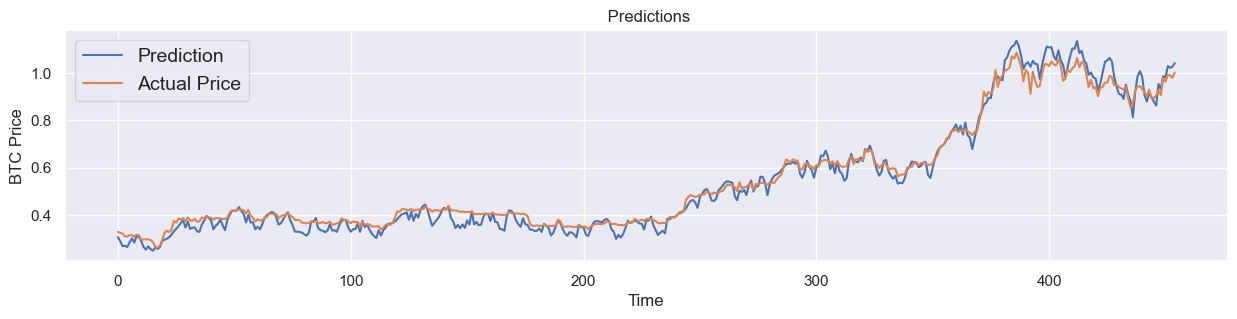

In [22]:
plot_loss_and_prediction(model_0,
                         X_test,
                         y_test)

## Bidirectional LSTM

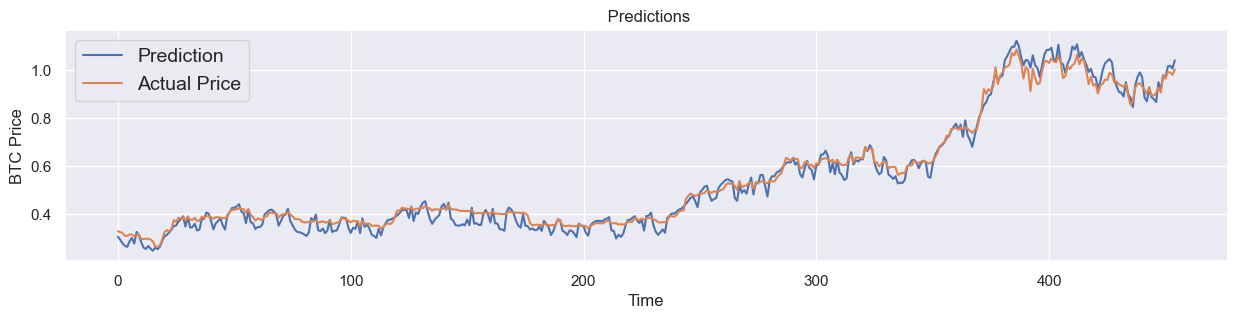

In [23]:
plot_loss_and_prediction(model_1,
                         X_test,
                         y_test)

## Encoder-Decoder LSTM

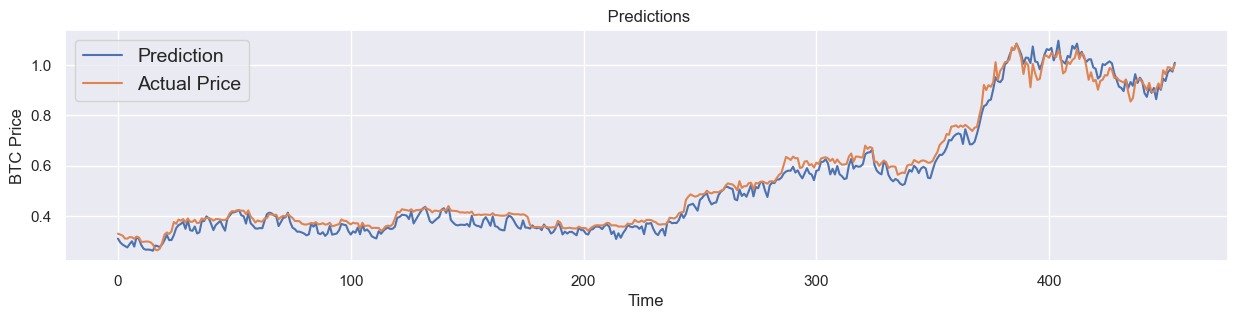

In [24]:
plot_loss_and_prediction(model_2,
                         X_test,
                         y_test)

## Convolutional LSTM

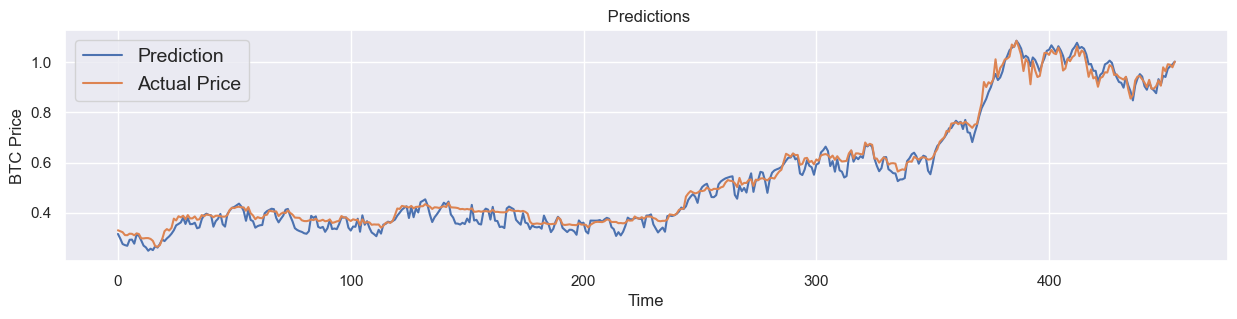

In [25]:
plot_loss_and_prediction(model_3,
                         X_test,
                         y_test)

## Comparison of each model

In [27]:
test_res_dir = 'results/test'
test_results = get_results_table(test_res_dir)
test_results

,mae,mse,rmse,mape,mase,model
0,0.017437,0.000467,0.017437,3.587974,21.814287,bilstm128
1,0.017357,0.000457,0.017357,3.565388,21.834259,bilstm256
2,0.024936,0.001001,0.024936,4.930526,22.606453,model_0_LSTM
3,0.024166,0.000901,0.024166,4.936173,22.390705,model_1_BiLSTM
4,0.247910,0.109858,0.318902,46.161293,22.043730,model_2_EDLSTM
5,0.021277,0.000707,0.021277,4.504421,22.089628,model_3_ConvLSTM
6,0.011246,0.000333,0.018238,1.890837,0.998550,naive


# Model Architecture

In [ ]:
k.utils.plot_model(model_0, 'model_architectures/model_0_LSTM.png')
k.utils.plot_model(model_1, 'model_architectures/model_1_BiLSTM.png')
k.utils.plot_model(model_2, 'model_architectures/model_2_EDLSTM.png')
k.utils.plot_model(model_3, 'model_architectures/model_3_ConvLSTM.png')